# Creating a Deep Completion Chart with Python

<br>

**Table of Contents:**

- [Outline](#Outline)
- [Libraries](#Libraries)
- [Extracting Data from a Single Game](#Extracting-Data-from-a-Single-Game)
    - [Scraping the Data](#Scraping-the-Data) <br>
    - [Extracting Deep Completion Information](#Extracting-Deep-Completion-Information) <br>
        - [(Starting) Location](#(Starting)-Location) <br>
        - [End Location - Passes](#End-Location---Passes) <br>
        - [End Location - Carries](#End-Location---Carries) <br>
        - [Merging the Two DataFrames](#Merging-the-Two-DataFrames) <br>
        - [Calculating Distance to Goal](#Calculating-Distance-to-Goal) <br>
    - [Turning Code Into a Function](#Turning-Code-Into-a-Function)
- [Extracting Data from Multiple Games](#Extracting-Data-from-Multiple-Games)
- [Creating Deep Completion Figures](#Creating-Deep-Completion-Figures)
    - [Default Parameters](#Default-Parameters)  <br>
    - [Functions](#Functions)  <br>
    - [📊 Figures](#Figures)  <br>
        - [⭐ Raheem Sterling in the Euro 2020](#Raheem-Sterling-in-the-Euro-2020) <br>
        - [⭐ Top Four Players](#Top-Four-Players) <br>
        - [⭐ Top Four Teams](#Top-Four-Teams) <br>
        - [⭐ Wingers VS Backs Comparison](#Wingers-VS-Backs-Comparison) <br>
- [Conclusions](#Conclusions)

<br>

# Outline

This notebook focuses on the [2020 UEFA European Football Championship](https://www.uefa.com/uefaeuro-2020/); however, the analysis can be easily replicated for other competitions. All data are extracted from [Statsbomb](https://statsbomb.com/academy/)’s [repository](https://github.com/statsbomb/open-data) hosted on GitHub.

Initially, we will start our analysis by focusing on a single football match (Section: **[Extracting Data from a Single Game](#Extracting-Data-from-a-Single-Game)**). We will learn how to process the raw data from Statsbomb’s repository and extract information on **deep completions** (synonym: **deep progressions**).

Then, we will scale our approach and extract deep completions from all matches in the competition (Section: **[Extracting Data from Multiple Games](#Extracting-Data-from-Multiple-Games)**).

Finally, once the final dataset is ready, we can visualise deep completions (Section: **[Creating Deep Completion Figures](#Creating-Deep-Completion-Figures)**).

<br>

# Libraries

In [1]:
# Data Handling and Analysis
import time
import random
import numpy as np
import pandas as pd

# Data Visualisation
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

import matplotlib.patches as patches
import matplotlib.image as image

from highlight_text import ax_text, fig_text

# Data Scraping
import json
import requests

# Football Pitch Visualisation
from mplsoccer import Pitch, VerticalPitch, add_image

# Filtering out warnings
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

# Miscellaneous
from tqdm.notebook import tqdm

In [2]:
print('Python Version:')
!python -V

Python Version:


Python 3.6.8 :: Anaconda, Inc.


In [3]:
# Uncomment the code below for a list of packages and their versions:

# %load_ext watermark
# %watermark -v -m -p numpy,pandas,matplotlib,highlight_text,json,requests,mplsoccer,tqdm

<br> 

# Extracting Data from a Single Game

We start by analysing a single football match. Specifically, we will explore the [game](https://www.youtube.com/watch?v=RnZBO0YCrYw) between England and Germany on the 29th of June, 2021, for the UEFA Euro 2020. This particular match has the ID ‘[3794688](https://github.com/statsbomb/open-data/blob/master/data/events/3794688.json)’ in Statsbomb’s database. 

<br>

## Scraping the Data

The first step is extracting the data from StatsBomb’s GitHub repository. For this purpose, we need to provide a number that uniquely identifies the game of interest in the events folder. This number is stored in the `match_id` variable. Then, we send a GET request to the specified URL using the `get()` method and save the response object to a separate variable called `response`. The scrapped data are not in a readable format immediately after scraping. Therefore, we need to use the `json` library to convert the text data into a Python dictionary.

In [4]:
match_id = '3794688'
event_base_url = 'https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{}.json'
url = event_base_url.format(match_id)

response = requests.get(url=url)

match_dict = json.loads(response.text)

We can now extract the team names:

In [5]:
pd.DataFrame({'Home': match_dict[0]['team']['name'],
              'Away': match_dict[1]['team']['name']},
             index=['Team'])

,Home,Away
Team,England,Germany


Additionally, we can store all events in a tabular format as a Pandas DataFrame.

In [6]:
df = pd.json_normalize(match_dict, sep='_')
df['count'] = 1  # Useful for counting elements in groupby statements

print('The DataFrame contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
print('First five rows:')
df.head()

The DataFrame contains 3454 rows and 117 columns.
First five rows:


,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,...,substitution_outcome_name,substitution_replacement_id,substitution_replacement_name,pass_goal_assist,50_50_outcome_id,50_50_outcome_name,dribble_overrun,miscontrol_aerial_won,shot_one_on_one,count
0,01896fd2-6f2b-40f0-8243-bdf92ae97394,1,1,00:00:00.000,0,0,1,0.00000,35,Starting XI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,359ba603-3336-488b-9cc8-c28cc793d197,2,1,00:00:00.000,0,0,1,0.00000,35,Starting XI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,180defd1-ab43-4b31-9d77-6ff5170a2bd4,3,1,00:00:00.000,0,0,1,0.00000,18,Half Start,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,87233b72-4993-4dfb-97ad-98efc47295fe,4,1,00:00:00.000,0,0,1,0.00000,18,Half Start,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,60cf1447-85af-4562-85a2-6705c59c29c0,5,1,00:00:00.543,0,0,2,1.47309,30,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


Having isolated the data into a DataFrame, we can easily extract each team's total number of events.

In [7]:
df.groupby(['team_name']).count()['count'].to_frame(name='# of Events')

,# of Events
team_name,
England,1671
Germany,1783


Also, we can create a table with information about all the goals of the match. 

In [8]:
goals_df = df[df['shot_outcome_name'] == 'Goal']
goals_df = goals_df[['team_name', 'player_name', 'minute']].sort_values(by='minute')

goals_df.index = np.arange(1, len(goals_df) + 1)
goals_df.index.name = 'Goal'
goals_df.columns = ['Team', 'Scorer', 'Minute']

goals_df

,Team,Scorer,Minute
Goal,,,
1,England,Raheem Sterling,74
2,England,Harry Kane,85


Before we proceed, it will be good to know what types of events are present in our DataFrame. We can access that information using the `value_counts()` method on the 'type_name' column.

In [9]:
df['type_name'].value_counts().to_frame(name='Count')

,Count
Pass,1034
Ball Receipt*,1007
Carry,774
Pressure,253
Duel,68
Ball Recovery,62
Clearance,48
Foul Committed,25
Foul Won,25
Dribble,19


The DataFrame contains information about 1034 passes and 774 carries.

<br>

## Extracting Deep Completion Information

### (Starting) Location

We start by examining the 'location' column, which stores the xy coordinates of the position where the event **started**.

In [10]:
print("NaN values in 'location':", df['location'].isnull().sum())

NaN values in 'location': 25


The 'location' column contains 25 NaN (i.e. missing) values, which we can discard:

In [11]:
df = df.dropna(subset=['location']).reset_index(drop=True)

Coordinates in ‘location’ are stored as a list, i.e. in the format [‘x’, ‘y’]. For our analysis, it is preferable to store the x and y coordinates as numbers (floats) in separate columns.

In [12]:
df[['x', 'y']] = pd.DataFrame(df['location'].values.tolist(), index=df.index)

df[['location', 'x', 'y']].head()

,location,x,y
0,"[60.0, 40.0]",60.0,40.0
1,"[46.3, 34.7]",46.3,34.7
2,"[46.3, 34.9]",46.3,34.9
3,"[45.9, 46.0]",45.9,46.0
4,"[46.5, 45.6]",46.5,45.6


We perform the same steps for the **end** location of events. We focus on only passes ('pass_end_location') and carries ('carry_end_location').

<br>

### End Location - Passes

In [13]:
pass_df = df.dropna(subset=['pass_end_location'])

pass_df[['pass_end_x', 'pass_end_y']] = pd.DataFrame(pass_df['pass_end_location'].values.tolist(),
                                                     index=pass_df.index)

<br>

### End Location - Carries

In [14]:
carry_df = df.dropna(subset=['carry_end_location'])

carry_df[['carry_end_x', 'carry_end_y']] = pd.DataFrame(carry_df['carry_end_location'].values.tolist(),
                                                        index=carry_df.index)

<br>

### Merging the Two DataFrames

We now merge the two DataFrames by appending the rows of `carry_df` to the end of `pass_df`. Notice that rows corresponding to a pass contain a NaN value in the 'carry_end_x' and 'carry_end_y' columns (and vice versa for carries).

In [15]:
df_tot = pass_df.append(carry_df, sort=False)

cols = ['x', 'y', 'pass_end_x', 'pass_end_y', 'carry_end_x', 'carry_end_y']
df_tot[cols].head()

,x,y,pass_end_x,pass_end_y,carry_end_x,carry_end_y
0,60.0,40.0,46.3,34.7,NaN,NaN
2,46.3,34.9,45.9,46.0,NaN,NaN
4,46.5,45.6,32.9,35.7,NaN,NaN
7,30.0,36.1,45.6,75.8,NaN,NaN
10,42.2,70.8,104.6,41.9,NaN,NaN


In [16]:
print('Number of rows:', df_tot.shape[0])

Number of rows: 1808


<br>

### Calculating Distance to Goal

Finally, we can calculate the initial and final distances from the goal for both passes and carries. The code in this section is copied from [CJ Mayes' and Yash's analysis](https://cj-mayes.com/2022/01/05/deep-progression-chart-yash-t/) (you can access their code directly on [Google Drive](https://drive.google.com/drive/folders/1paYL4HKjKF2IJyJbRwwZXmjMDODBr44a)).

In [17]:
df_tot['initial_distance'] = np.sqrt(((120 - df_tot['x'])**2) +
                                     ((40 - df_tot['y'])**2))

df_tot['final_distance_pass'] = np.sqrt(((120 - df_tot['pass_end_x'])**2) +
                                        ((40 - df_tot['pass_end_y'])**2))

df_tot['final_distance_carry'] = np.sqrt(((120 - df_tot['carry_end_x'])**2) +
                                         ((40 - df_tot['carry_end_y'])**2))

After calculating the initial and final distances from the goal, we can determine whether an action can be classified as deep or not.

In [18]:
df_tot['is_deep_completion'] = np.where(
    ((df_tot['final_distance_pass'] <= 21.87) & (df_tot['initial_distance'] >= 21.87) |
     ((df_tot['final_distance_carry'] <= 21.87) & (df_tot['initial_distance'] >= 21.87))), True, False)

In [19]:
deep_completion_no = df_tot[df_tot['is_deep_completion'] == True].shape[0]
print('Number of deep completions: ', deep_completion_no)

Number of deep completions:  63


However, we still need to exclude actions from corners and incomplete actions:

In [20]:
deep_completion_df = df_tot.loc[(df_tot['play_pattern_name'] != 'From Corner')
                                & (df_tot['pass_outcome_name'] != 'Incomplete')
                                & (df_tot['is_deep_completion'] == True)]

deep_completion_no = deep_completion_df.shape[0]
print('Number of deep completions: ', deep_completion_no)

Number of deep completions:  27


Therefore, out of all 1808 passes and carries, only 27 can be classified as deep completions. Since our data processing analysis is complete, we can view the top of our new DataFrame:

In [21]:
cols = [
    'player_name', 'team_name', 'x', 'y', 'pass_end_x', 'pass_end_y',
    'carry_end_x', 'carry_end_y', 'initial_distance', 'final_distance_pass',
    'final_distance_carry'
]

deep_completion_df[cols].head()

,player_name,team_name,x,y,pass_end_x,pass_end_y,carry_end_x,carry_end_y,initial_distance,final_distance_pass,final_distance_carry
505,Kieran Trippier,England,116.2,69.4,111.0,32.8,NaN,NaN,29.644561,11.525624,NaN
931,Luke Shaw,England,87.5,19.4,112.4,49.9,NaN,NaN,38.478695,12.480785,NaN
1206,Joshua Kimmich,Germany,100.9,60.2,119.6,27.4,NaN,NaN,27.800180,12.606348,NaN
1220,Kai Havertz,Germany,85.8,24.6,111.5,27.5,NaN,NaN,37.507333,15.116216,NaN
1332,Toni Kroos,Germany,53.8,41.6,103.3,53.6,NaN,NaN,66.219333,21.537177,NaN


<br>

## Turning Code Into a Function

We can automate the data processing step by turning our analysis into a single function.

In [22]:
def get_match_df(match_id):
    '''Extracts and returns a DataFrame for a single match (specified by its ID).'''
    url = event_base_url.format(match_id)
    response = requests.get(url=url)

    match_dict = json.loads(response.text)

    return pd.json_normalize(match_dict, sep='_')

In [23]:
def get_deep_completions_per_game(match_id):
    '''Processes deep completion data and returns a DataFrame.'''
    # Step 01: Get the data
    df = get_match_df(match_id)
    df['count'] = 1

    # Step 02: Remove NaNs in location and extract `x` and `y` coordinates
    df = df.dropna(subset=['location']).reset_index(drop=True)
    df[['x', 'y']] = pd.DataFrame(df['location'].values.tolist(), index=df.index)

    # Step 03: Remove NaNs in 'pass_end_location' and extract coordinated
    pass_df = df.dropna(subset=['pass_end_location'])
    pass_df[['pass_end_x', 'pass_end_y']] = pd.DataFrame(pass_df['pass_end_location'].values.tolist(),
                                                         index=pass_df.index)

    # Step 04: Repeat for 'carry_end_location'
    carry_df = df.dropna(subset=['carry_end_location'])
    carry_df[['carry_end_x', 'carry_end_y']] = pd.DataFrame(carry_df['carry_end_location'].values.tolist(),
                                                            index=carry_df.index)

    # Step 05: Merge the two dataframes
    df_tot = pass_df.append(carry_df, sort=False)

    # Step 06: Calculate initial and final distance for all passes and carries
    df_tot['initial_distance'] = np.sqrt(((120 - df_tot['x'])**2) +
                                         ((40 - df_tot['y'])**2))

    df_tot['final_distance_pass'] = np.sqrt(((120 - df_tot['pass_end_x'])**2) +
                                            ((40 - df_tot['pass_end_y'])**2))

    df_tot['final_distance_carry'] = np.sqrt(((120 - df_tot['carry_end_x'])**2) + 
                                             ((40 - df_tot['carry_end_y'])**2))

    # Step 07: Filter our all events that are not deep completions
    df_tot['is_deep_completion'] = np.where(
        ((df_tot['final_distance_pass'] <= 21.87) & (df_tot['initial_distance'] >= 21.87) |
         ((df_tot['final_distance_carry'] <= 21.87) & (df_tot['initial_distance'] >= 21.87))), True, False)

    # Step 08: Exclude actions from corners and incomplete actions
    deep_completion_df = df_tot.loc[
        (df_tot['play_pattern_name'] != 'From Corner')
        & (df_tot['pass_outcome_name'] != 'Incomplete')
        & (df_tot['is_deep_completion'] == True)]

    return deep_completion_df

In [24]:
deep_completion_df_2 = get_deep_completions_per_game(match_id)
deep_completion_df_2[cols].head()

,player_name,team_name,x,y,pass_end_x,pass_end_y,carry_end_x,carry_end_y,initial_distance,final_distance_pass,final_distance_carry
505,Kieran Trippier,England,116.2,69.4,111.0,32.8,NaN,NaN,29.644561,11.525624,NaN
931,Luke Shaw,England,87.5,19.4,112.4,49.9,NaN,NaN,38.478695,12.480785,NaN
1206,Joshua Kimmich,Germany,100.9,60.2,119.6,27.4,NaN,NaN,27.800180,12.606348,NaN
1220,Kai Havertz,Germany,85.8,24.6,111.5,27.5,NaN,NaN,37.507333,15.116216,NaN
1332,Toni Kroos,Germany,53.8,41.6,103.3,53.6,NaN,NaN,66.219333,21.537177,NaN


It seems that our custom function returned the same DataFrame as the individual pre-processing steps. We can use Pandas’ `equals()` method to confirm that the two DataFrames are indeed identical.

In [25]:
deep_completion_df.equals(deep_completion_df_2)

True

<br>

# Extracting Data from Multiple Games

Having defined the `get_deep_completions_per_game()` function, we can scale our approach and extract data from multiple games. We only need to provide the competition id, the season id and the competition name. This information can be accessed from  the [competitions.json](https://github.com/statsbomb/open-data/blob/master/data/competitions.json) file from StatsBomb's [GitHub repository](https://github.com/statsbomb/open-data).

In [26]:
competition_id = 55
season_id = 43
competition_name = 'EURO 2022'

The data extraction process is divided into two functions. The first one, `get_comp_match_ids()`, extracts and returns the ids for all matches during the specified season of the competition. The second one, `get_deep_completions_per_comp()`, extracts the deep completion data and appends them to a DataFrame.

In [27]:
def get_comp_match_ids(competition_id, season_id):
    '''Returns the ids for all matches taking place during the specified season of the competition.'''
    comp_base_url = 'https://raw.githubusercontent.com/statsbomb/open-data/master/data/matches/{}/{}.json'
    url = comp_base_url.format(competition_id, season_id)

    matches = requests.get(url=url).json()
    match_ids = [m['match_id'] for m in matches]
    print('Number of games in this competition:', len(match_ids))

    return match_ids

In [28]:
def get_deep_completions_per_comp(competition_id, season_id, df_tot):
    '''Returns a DataFrame with all deep completions taking place during the specified season of the competition.'''
    match_ids = get_comp_match_ids(competition_id, season_id)

    for match_id in tqdm(match_ids):

        df_tot = df_tot.append(get_deep_completions_per_game(match_id))

        # Add a random delay time between 0.1 and 1 s
        time.sleep(random.uniform(0.1, 1))

    print('Web Scraping: Complete!')
    return df_tot.reset_index(drop=True)

In [29]:
df_tot = get_deep_completions_per_comp(competition_id,
                                       season_id,
                                       df_tot=pd.DataFrame())

Number of games in this competition: 51



Web Scraping: Complete!


Scraping is now complete. We can view how many deep completions are there in total.

In [30]:
print('Total number of deep completions in the competition:', df_tot.shape[0])

Total number of deep completions in the competition: 1411


Additionally, we can view the players with the highest number of deep completions. 

In [31]:
df_tot_pl = df_tot.groupby(['player_name', 'team_name']).count()
df_tot_pl = df_tot_pl.reset_index(1)
df_tot_pl = df_tot_pl[['team_name', 'count', 'final_distance_pass', 'final_distance_carry']]
df_tot_pl.sort_values(by='count', ascending=False, inplace=True)

df_tot_pl.index.names = ['Player']
df_tot_pl.columns = ['Team', 'Total', 'Passes', 'Carries']

df_tot_pl.head(10)

,Team,Total,Passes,Carries
Player,,,,
Lorenzo Insigne,Italy,25,16,9
Joakim Mæhle,Denmark,25,10,15
Raheem Sterling,England,22,7,15
Luke Shaw,England,20,17,3
Jordi Alba Ramos,Spain,19,17,2
Mason Mount,England,18,10,8
Gareth Frank Bale,Wales,17,16,1
Leonardo Spinazzola,Italy,16,6,10
Memphis Depay,Netherlands,16,7,9


Lastly, we will export the processed DataFrame into a new CSV file. This step will enable us to access the data without performing the processing steps again.

In [32]:
file_name = 'Dataset-{}.csv'.format(competition_name.replace(' ', '_'))
df_tot.to_csv(file_name, index=False)

<br>

# Creating Deep Completion Figures

Creating deep Completion figures is divided into three subsections. Firstly, we will define some default parameters (such as pitch colour, text font, etc.) for our figures.

Then, we will define six functions used for creating the figures. Each function adds new elements to a plot. The default parameters are optimised for a single plot (1 row and 1 column). The user needs to tweet some parameters if more subplots are added.

Finally, we will create four separate figures. Specifically, we will create a single (1 x 1) figure for one player (Rahim Sterling) and three 2 x 2 figures for: 

- The four players with the highest number of deep completions (Joakim Mæhle, Lorenzo Insigne, Raheem Sterling, and Luke Shaw),
- All deep completions performed by (right- and left-) backs and wingers, and
- The four teams with the highest number of deep completions (Spain, Italy, England, and Denmark).

<br>

## Default Parameters

In [33]:
pitch_color = '#0f253a'
face_color = pitch_color
line_color = 'white'
zone_color = 'tab:orange'
pass_color = 'tab:blue'
carry_color = 'tab:red'

radius = 21.87  # radius of the penalty box to draw the arc

plt.rcParams['text.color'] = 'white'
plt.rcParams['font.family'] = 'Century Gothic'
plt.rcParams['font.weight'] = 'bold'

highlight_textprops =\
    [{'color': pass_color, 'fontweight': 'bold'},
     {'color': carry_color, 'fontweight': 'bold'},
     {'color': zone_color, 'fontweight': 'normal'}
    ]

subtitle = 'A <completed pass> or <carry> that ends in the <highlighted zone> | {}'.format(competition_name)

<br>

## Functions

In [34]:
def create_pitch_axes(nrows,
                      ncols,
                      figheight=9,
                      title_height=0.13,
                      grid_height=0.78,
                      space=0.05):
    '''Creates a pitch object and adds the highlighted area.'''
    ### 01 - Create the pitch object ###
    pitch = VerticalPitch(
        pitch_type='statsbomb',
        half=True,
        pitch_color=pitch_color,
        line_color=line_color,
        linewidth=2,
        spot_scale=0.0,  # remove centre and penalty spots
        pad_bottom=0.5,
        pad_top=0.1,
        tight_layout=True,
        constrained_layout=True)

    fig, ax = pitch.grid(figheight=figheight,
                         nrows=nrows,
                         ncols=ncols,
                         endnote_height=0.0,
                         endnote_space=0.0,
                         grid_height=grid_height,
                         title_height=title_height,
                         space=space,
                         axis=False)
    fig.set_facecolor(pitch_color)

    ### 02 - Add highlighed area ###
    for i in np.arange(0, ncols * nrows):
        circle = patches.Circle([40, 120],
                                radius=radius,
                                facecolor='none',
                                edgecolor=zone_color,
                                linewidth=3,
                                linestyle='--')

        if ncols > 1 or nrows > 1:
            ax['pitch'].flatten()[i].add_patch(circle)
        else:
            ax['pitch'].add_patch(circle)

    return fig, ax, pitch

In [35]:
def add_title(fig, title='Deep Completion Chart', fontsize=32):
    '''Adds a title to the figure.'''
    fig.suptitle(title, fontsize=fontsize, fontweight='bold', y=0.995)

In [36]:
def add_subtitle(subtitle, x=0.500, y=0.915, fontsize=20):
    '''Adds a subtitle to the figure.'''
    fig_text(s=subtitle,
             x=x,
             y=y,
             size=fontsize,
             fontweight='normal',
             highlight_textprops=highlight_textprops,
             ha='center',
             va='center')

In [37]:
def add_acknowledgements(fontsize=20,
                         x=0.690,
                         y=0.016,
                         lg_left=0.70,
                         lg_bottom=-0.055,
                         lg_width=0.20,
                         lg_height=0.15):
    '''Adds an acknowledgement line at the bottom of the figure.'''
    ### 01 - Add acknowledgements ###
    fig_text(s='Created by: Konstantinos Orfanakis | Data: ',
             x=x,
             y=y,
             size=fontsize,
             fontweight='normal',
             ha='right',
             va='center')

    ### 02 - Add Statsbomb's logo ###
    ax_image = add_image(image.imread('Images/StatsBomb_Logo.png'),
                         fig,
                         left=lg_left,
                         bottom=lg_bottom,
                         width=lg_width,
                         height=lg_height)

In [38]:
def add_pitch_title(ax, selection, pitch_title=20):
    '''Adds a title on top of the pitch (specified by the axis 'ax' object).'''
    ax.set_title(str(selection),
                 size=pitch_title,
                 fontweight='bold',
                 pad=10,
                 bbox=dict(facecolor=pitch_color,
                           edgecolor=line_color,
                           linewidth=1,
                           pad=0.30,
                           boxstyle='round'))

In [39]:
def add_deep_completions(df, col, selection, ax, num_size=32, ms=15):
    '''Plots the deep completions for the entity (player or position) specified in the 'selection' argument.'''
    ### 01 - Calculate the number of deep completions ###
    df_sel = df[df[col] == selection]

    num_passes = df_sel[df_sel['final_distance_pass'].notnull()].shape[0]
    num_carries = df_sel[df_sel['final_distance_carry'].notnull()].shape[0]
    num_total = num_passes + num_carries

    ### 02 - Add number of deep passes + carries ###
    for x, number, text, ha, color in zip([28, 40, 52],
                                          [num_passes, num_total, num_carries],
                                          ['{} passes', '{}', '{} carries'],
                                          ['right', 'center', 'left'],
                                          [pass_color, 'white', carry_color]):
        ax.text(x=x,
                y=63,
                s=text.format(number),
                color=color,
                size=num_size,
                ha=ha,
                va='center')

    ### 03 - Add deep completions ###
    for dc_type, color in zip(['pass', 'carry'], [pass_color, carry_color]):

        pitch.lines(df_sel['x'],
                    df_sel['y'],
                    df_sel['{}_end_x'.format(dc_type)],
                    df_sel['{}_end_y'.format(dc_type)],
                    color=color,
                    alpha=0.7,
                    lw=2,
                    comet=True,
                    ax=ax)

        pitch.scatter(df_sel['{}_end_x'.format(dc_type)],
                      df_sel['{}_end_y'.format(dc_type)],
                      color=pitch_color,
                      edgecolors=color,
                      alpha=0.9,
                      linewidths=5,
                      s=ms,
                      ax=ax)

<br>

## Figures

### Raheem Sterling in the Euro 2020

Initially, we will visualise all deep completions created by a single player: Raheem Sterling.

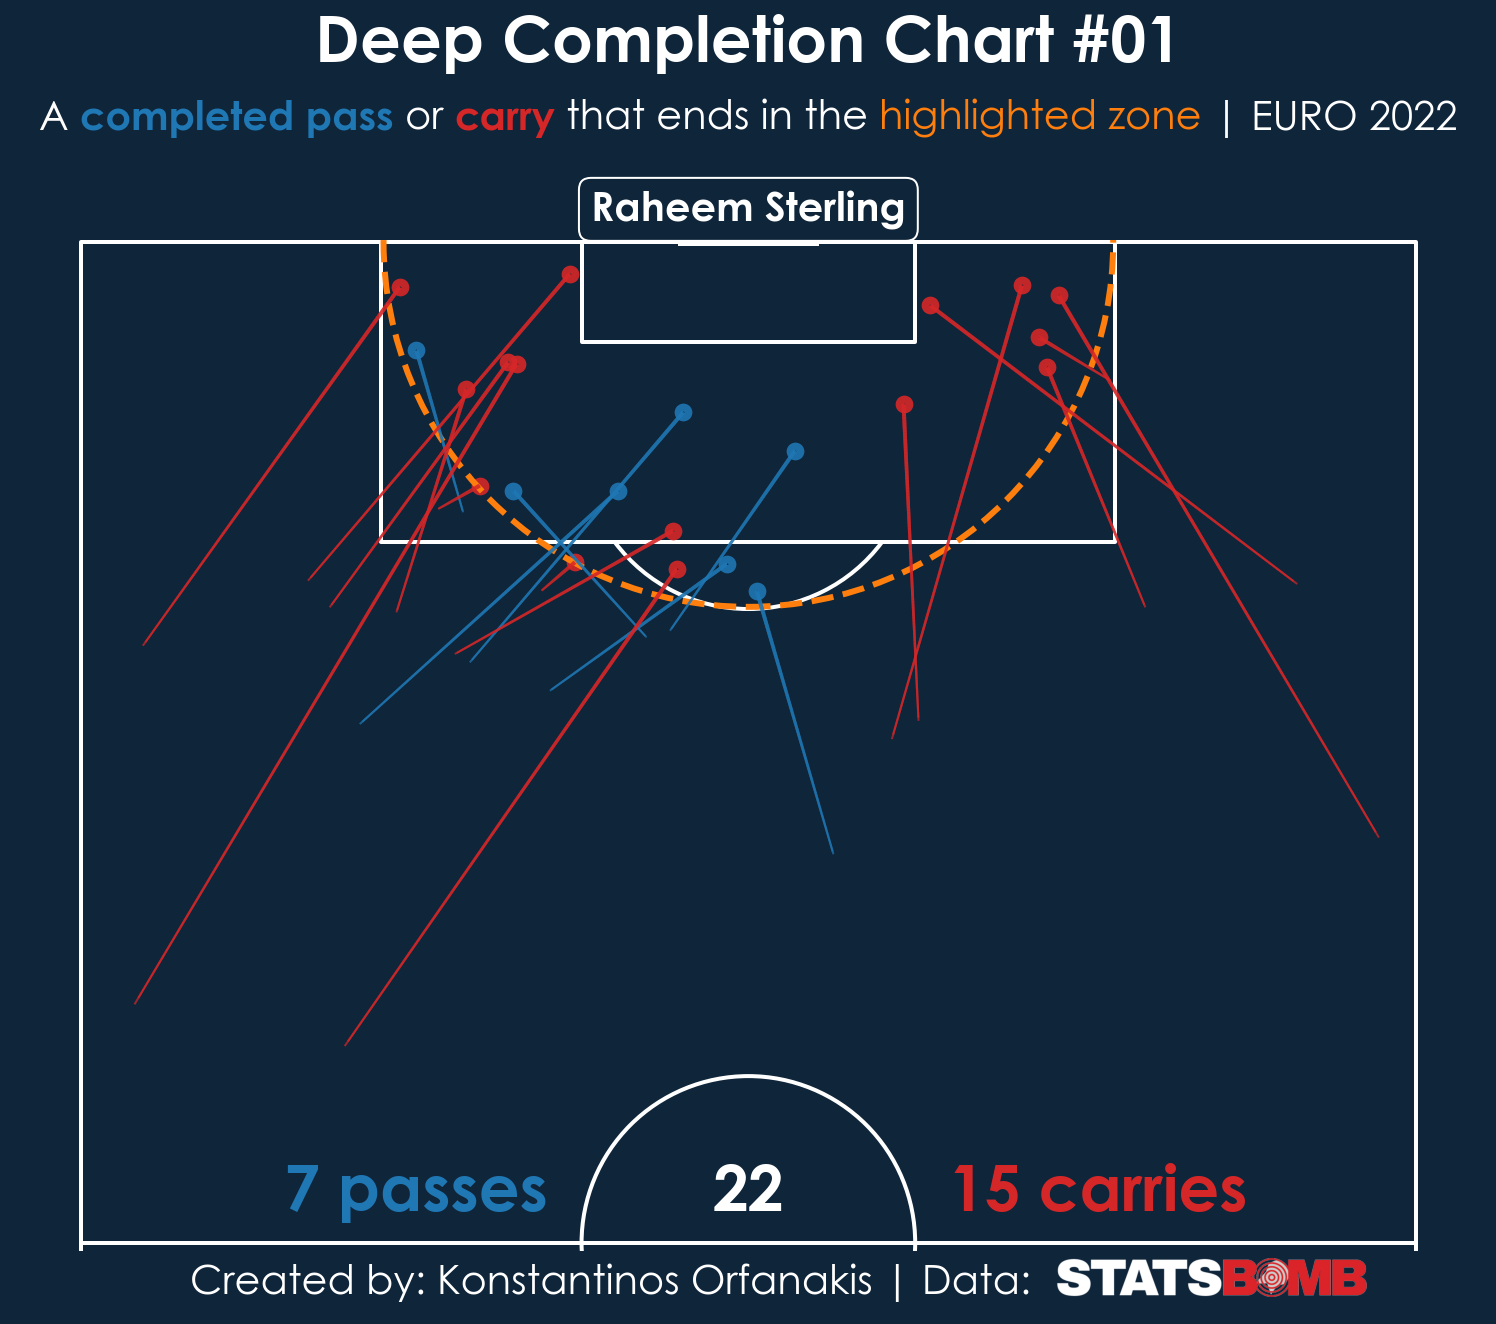

In [40]:
col = 'player_name'
selection = 'Raheem Sterling'

fig, ax, pitch = create_pitch_axes(nrows=1, ncols=1)
add_title(fig, title='Deep Completion Chart #01')
add_subtitle(subtitle)
add_pitch_title(ax['pitch'], selection)
add_deep_completions(df_tot, col, selection, ax['pitch'])
add_acknowledgements()

# plt.savefig('Images/Figure01-{}.png'.format(selection.replace(' ', '_')))

This figure demonstrates Raheem Sterling’s importance for England in the Euro 2020. He created a total of 22 deep completions, 15 of which were carries. Interestingly, Raheem Sterling had a ‘balanced’ presence by creating deep completions from both the right and left sides of the pitch.

<br>

### Top Four Players

We can then create a figure with four subplots, one for each of the four players with the highest number of deep completions.

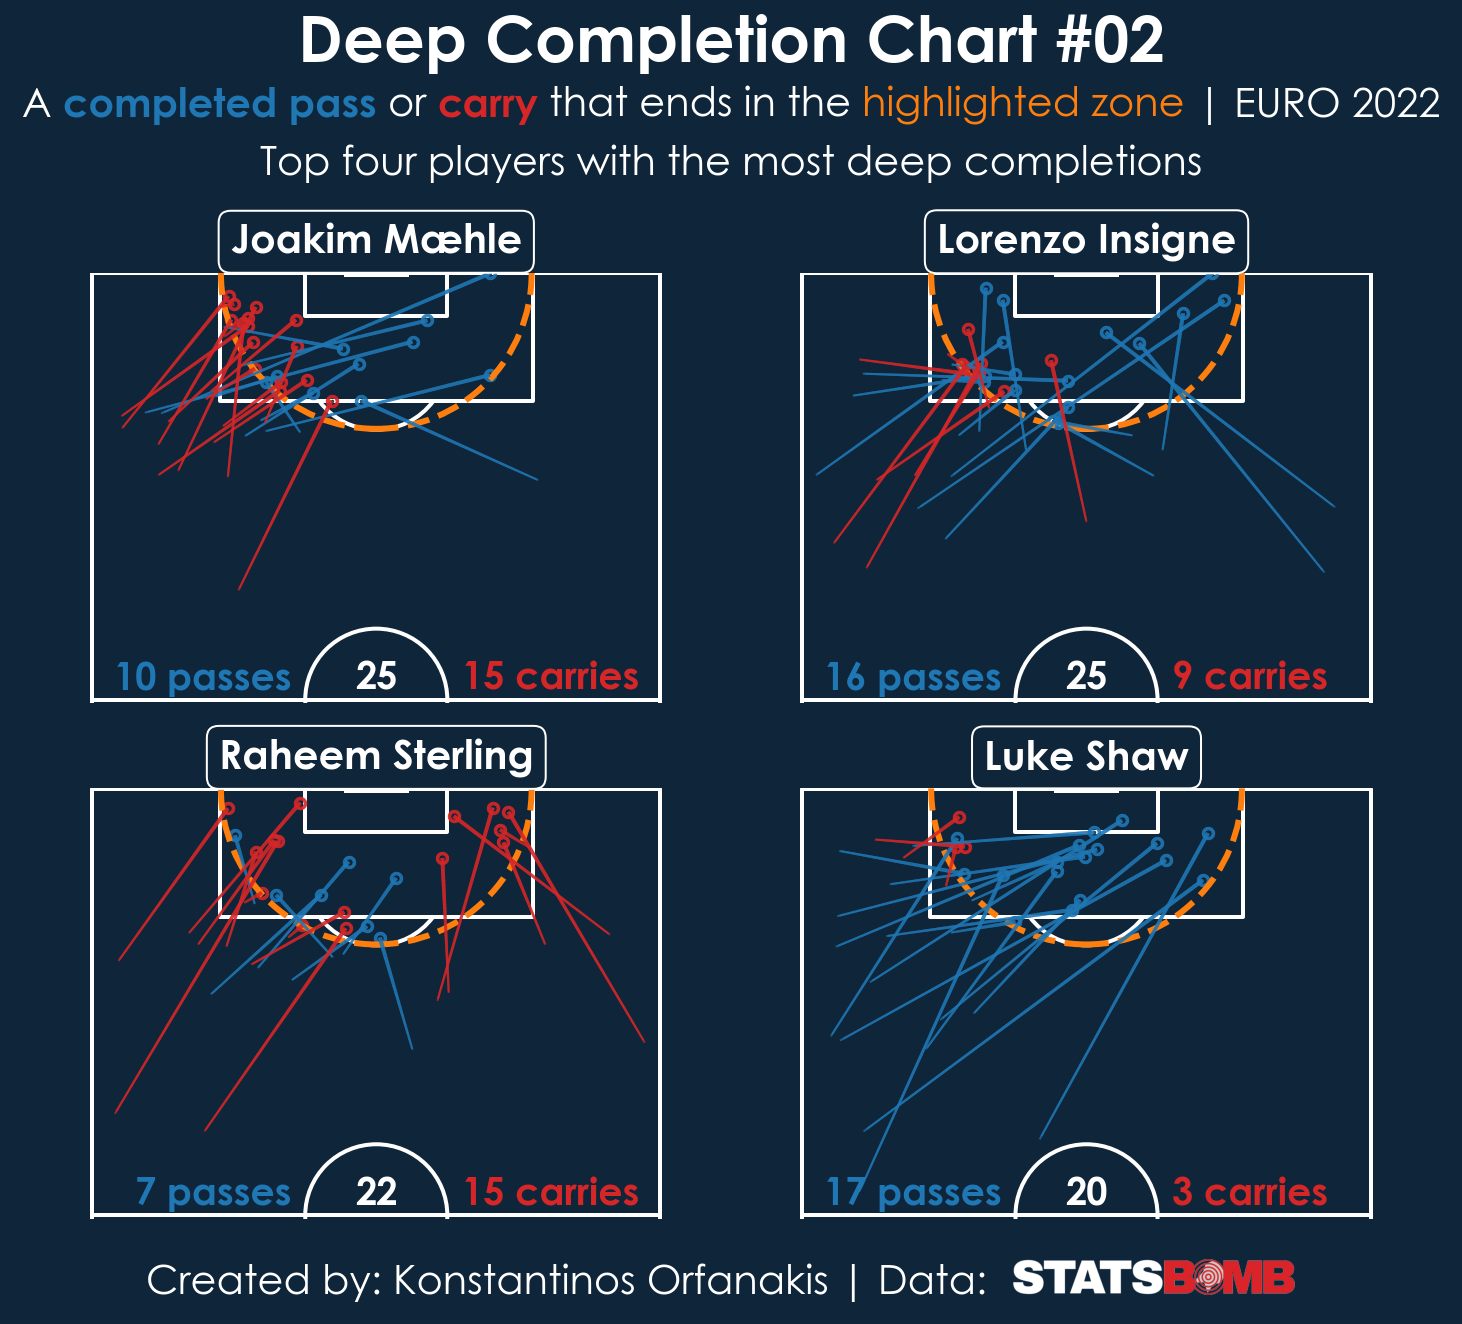

In [41]:
col = 'player_name'
players = list(df_tot['player_name'].value_counts().index[0:4])

nrows, ncols = 2, 2

fig, ax, pitch = create_pitch_axes(nrows=nrows, ncols=ncols, grid_height=0.73, space=0.09)
add_title(fig, title='Deep Completion Chart #02')
add_subtitle(subtitle, y=0.925)

fig_text(s='Top four players with the most deep completions',
         x=0.500,
         y=0.880,
         size=20,
         fontweight='normal',
         ha='center',
         va='center')

for i, selection in enumerate(players):
    ax_pitch = ax['pitch'].flatten()[i]

    add_pitch_title(ax_pitch, selection, pitch_title=20)
    add_deep_completions(df_tot, col, selection, ax_pitch, num_size=19, ms=3)

add_acknowledgements(fontsize=20)

# plt.savefig('Images/Figure02-Top_4_Players.png')

- Lorenzo Insigne and Joakim Mæhle are the joint-top creators in the tournament, creating a total of 25 deep completions each. 
- Luke Shaw, a left-back defender, is in fourth place as he completed 17 deep passes. It is not surprising that Shaw has considerably more passes than carries as defenders are naturally further away from the highlighted zone.

<br>

### Wingers VS Backs Comparison

Motivated by the presence of Luke Shaw in the top 4, I decided to visualise how wingers and backs create deep completions.

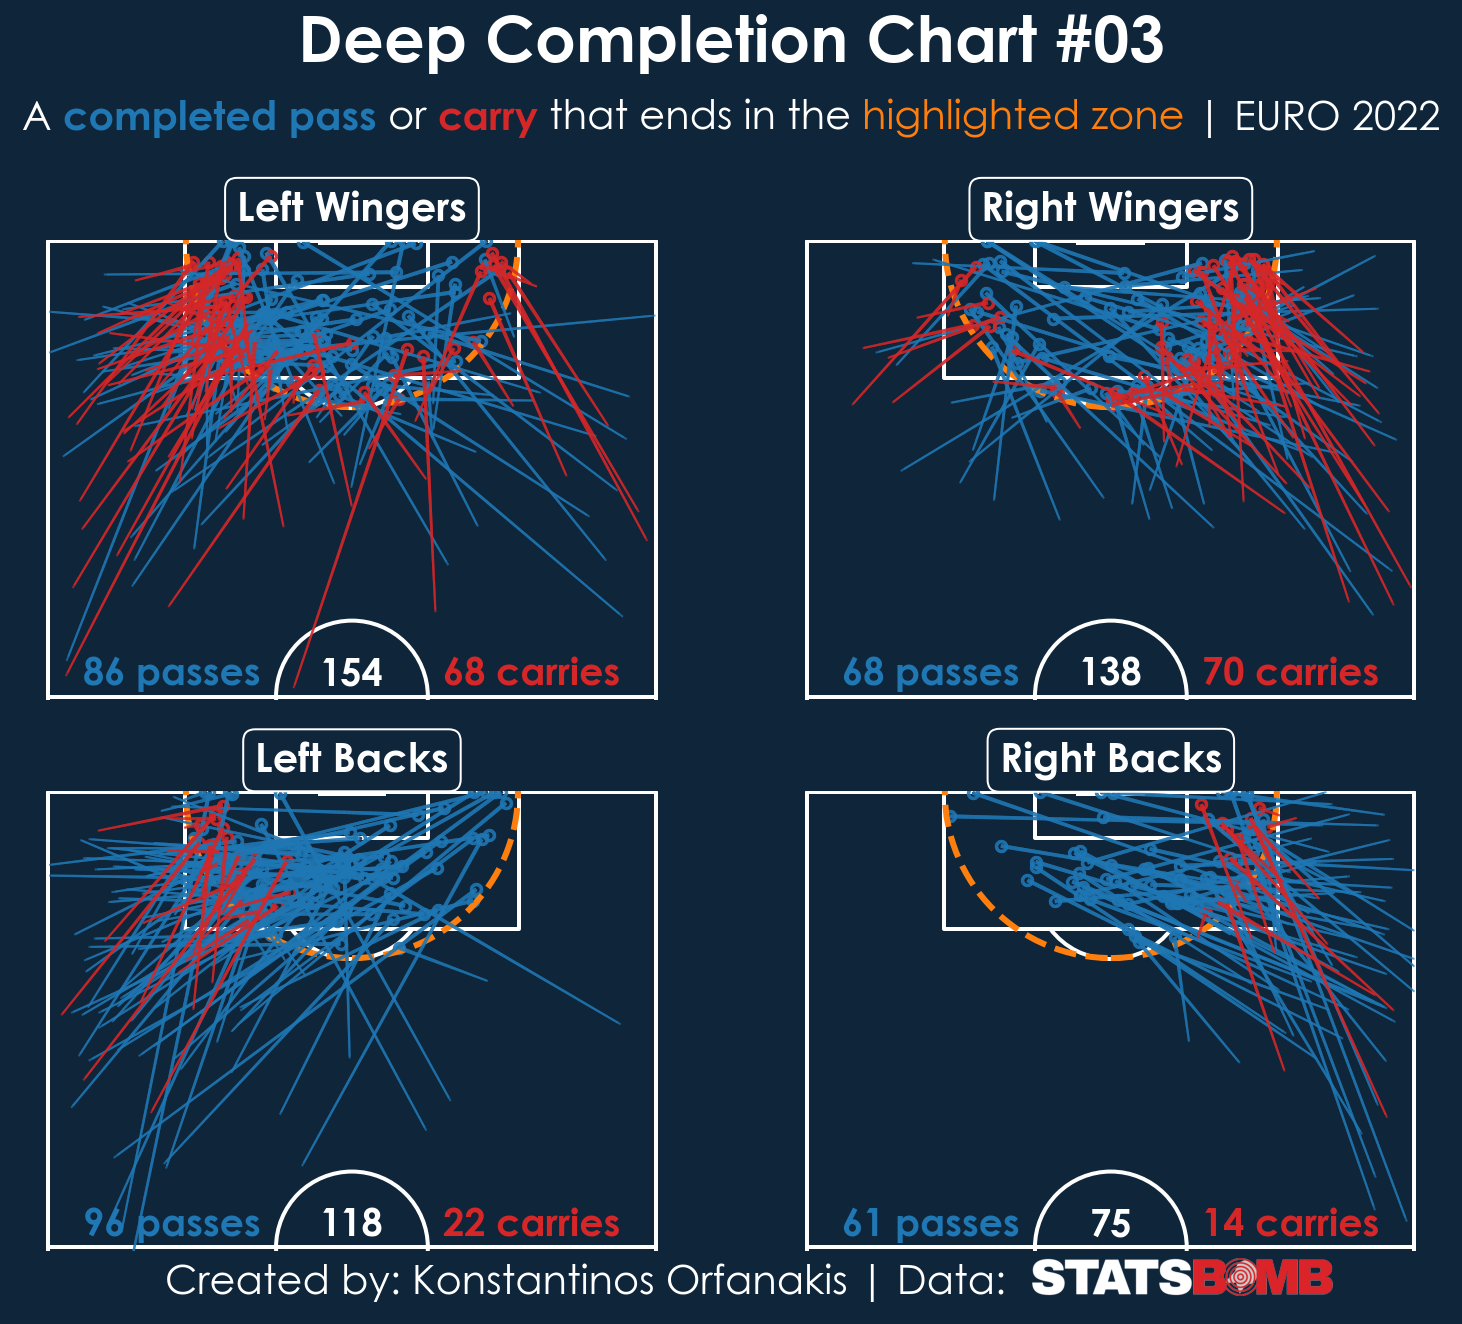

In [42]:
col = 'position_name'
positions = ['Left Wing', 'Right Wing', 'Left Back', 'Right Back']

nrows, ncols = 2, 2

fig, ax, pitch = create_pitch_axes(nrows=nrows, ncols=ncols, space=0.09)
add_title(fig, title='Deep Completion Chart #03')
add_subtitle(subtitle)

for i, selection in enumerate(positions):
    ax_pitch = ax['pitch'].flatten()[i]

    pitch_title = selection.split()[0] + ' ' + ('Wingers' if selection.split()[1] == 'Wing' else 'Backs')
    add_pitch_title(ax_pitch, pitch_title, pitch_title=20)
    add_deep_completions(df_tot, col, selection, ax_pitch, num_size=19, ms=3)

add_acknowledgements(fontsize=20)

# plt.savefig('Images/Figure03-Wingers_vs_Backs.png')

Again, it is not surprising that backs specialise in passes as they usually play away from the highlighted area. Contrary, wingers appear more balanced with comparable numbers for passes and carries. 

Notice that there is a significant gap in the number of deep passes between left- and right-backs. This discrepancy can be explained by the presence of two highly creative players, Luke Shaw and Jordi Alba, who usually play as left-backs.


<br>

### Top Four Teams

Instead of using individual players, we can use the previous code to plot deep completions for all players within a national team. 

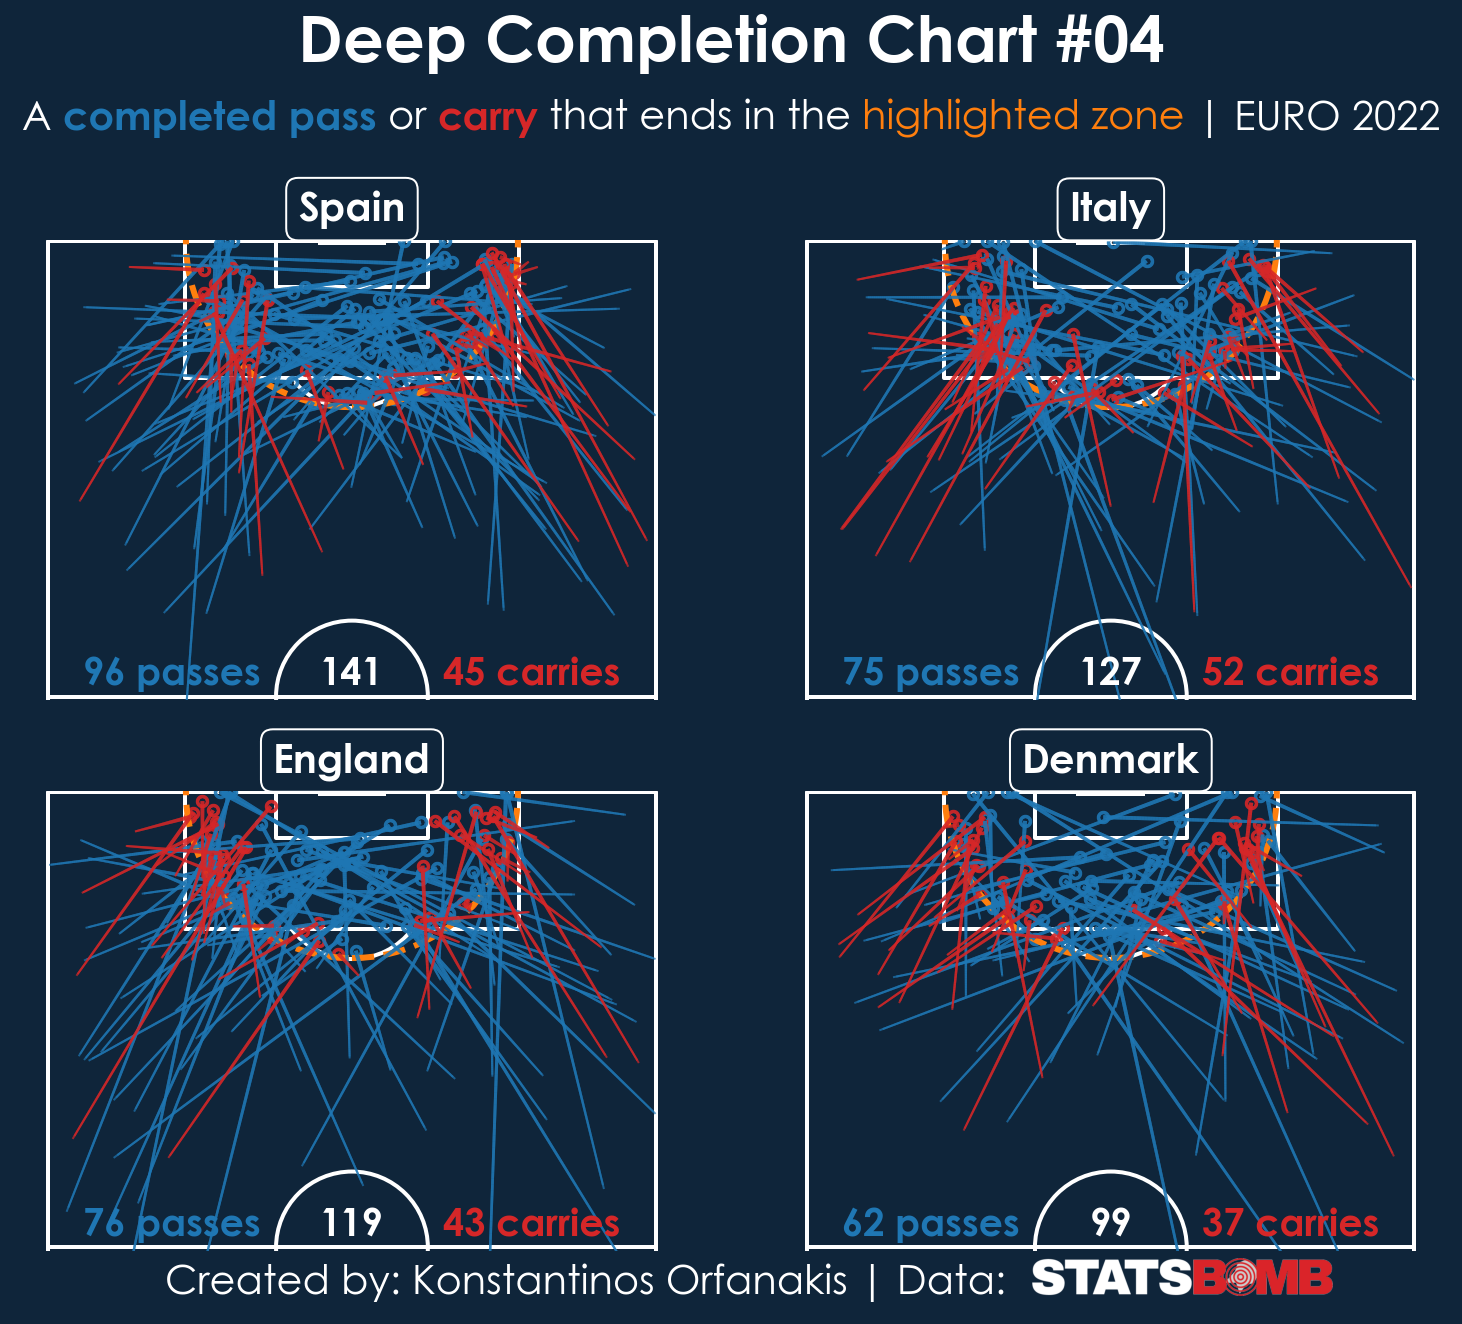

In [43]:
col = 'team_name'
teams = list(df_tot['team_name'].value_counts().index[0:4])

nrows, ncols = 2, 2

fig, ax, pitch = create_pitch_axes(nrows=nrows, ncols=ncols, space=0.09)
add_title(fig, title='Deep Completion Chart #04')
add_subtitle(subtitle)

for i, selection in enumerate(teams):
    ax_pitch = ax['pitch'].flatten()[i]

    add_pitch_title(ax_pitch, selection, pitch_title=20)
    add_deep_completions(df_tot, col, selection, ax_pitch, num_size=19, ms=3)

add_acknowledgements(fontsize=20)

# plt.savefig('Images/Figure04-Top_4_Teams.png')

We can not gain much information as plots get cluttered when the number of deep completions becomes high. We might benefit from using [heatmap](https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_plots/plot_heatmap.html#sphx-glr-gallery-pitch-plots-plot-heatmap-py), but that is out of scope for this notebook.

<br>

<br>

# Conclusions

In summary, in this project, we used Python to:

- Import open event data from Statsbomb’s GitHub repository,
- Process the data to extract information on deep completions, and
- Visualise deep completions.

The code is written so that a figure (or subfigure) contains deep completions for a single player, all players from a team, or all players in a single position.

<br>

---